In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/SP500.csv")

## Historical Returns Method

In [4]:
daily_returns = df['SP500'].pct_change()

/tmp/ipykernel_447919/3387636219.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = df['SP500'].pct_change()


In [5]:
# Rank the return series
sorted_returns = daily_returns.sort_values()

var_pct = input("Enter the percentage for VaR calculation (e.g., 95 for 95%): ")
# Convert the input to a float and divide by 100
var_pct_mut = float(100 - int(var_pct)) / 100

In [6]:
var_pct_mut

0.05

In [7]:
var = sorted_returns.quantile(var_pct_mut)
print(f"The {var_pct}% VaR is: {var}")

The 95% VaR is: -0.017060536295338758


## Parametric Method

In [8]:
from scipy.stats import norm

In [9]:
# Suppose that the price follows a normal distribution
# Calculate the mean and standard deviation of daily returns
mean = daily_returns.mean()
std_dev = daily_returns.std()
# Calculate the VaR using the normal distribution
quantile = norm.ppf(var_pct_mut, loc=0, scale=1)

In [10]:
var_return = mean + std_dev * quantile
print(f"The VaR using the normal distribution is: {var_return}")

The VaR using the normal distribution is: -0.018247157414266038


## Using Monte Carlo Method with Geometric Brownian Motion (GBM)

In [11]:
import numpy as np

The price change of an asset over a small time interval, expressed as a percentage of the current price, follows a normal distribution:

$
\frac{S_{t+dt} - S_t}{S_t} \sim N(\mu \cdot dt, \sigma^2 \cdot dt)
$

Where:
- $S_t$ : Current price of the asset at time $t$
- $S_{t+dt}$ : Price of the asset at time $t + dt$
- $\mu$ : Drift (average return)
- $\sigma$: Volatility (standard deviation of returns)
- $dt$ : Small time interval

In [12]:
mu = daily_returns.mean()
sigma = daily_returns.std()

In [13]:
def monte_carlo_gbm(start_price, mu, sigma, days=1, n_simulations=10_000):
    dt = 1 / 252  # Daily (assuming 252 trading days/year)
    simulated_returns = np.random.normal(mu * dt, sigma * np.sqrt(dt), (days, n_simulations))
    price_paths = start_price * (1 + simulated_returns).cumprod(axis=0)
    return price_paths

# Get latest S&P 500 price
latest_price = df['SP500'].iloc[-1]

# Run simulation (1-day ahead)
price_paths = monte_carlo_gbm(latest_price, mu, sigma, days=1, n_simulations=10_000)

In [25]:
price_paths

array([[5287.49728237, 5286.76878713, 5280.56047889, ..., 5282.20246373,
        5283.25258922, 5282.97776409]])

In [19]:
simulated_returns = (price_paths[-1] / latest_price) - 1  # For GBM

In [26]:
var_95 = np.percentile(simulated_returns, 5)
print(f"1-Day 95% VaR: {var_95 * 100:.2f}%")
print(f"Absolute VaR for ${latest_price:.0f} portfolio: ${latest_price * var_95:.2f}")

1-Day 95% VaR: -0.12%
Absolute VaR for $5283 portfolio: $-6.14


In [28]:
import matplotlib.pyplot as plt

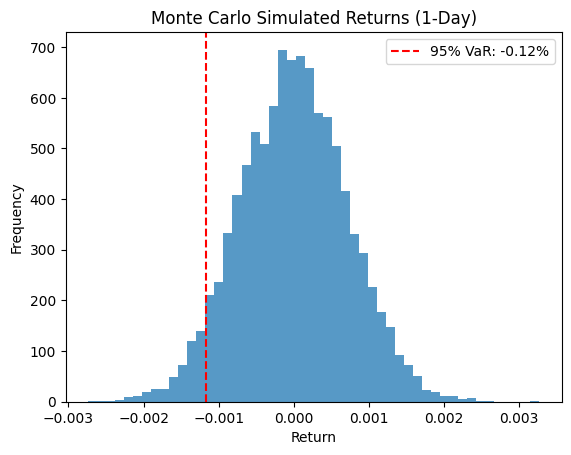

In [29]:
plt.hist(simulated_returns, bins=50, alpha=0.75)
plt.axvline(x=var_95, color='red', linestyle='--', label=f'95% VaR: {var_95 * 100:.2f}%')
plt.title('Monte Carlo Simulated Returns (1-Day)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

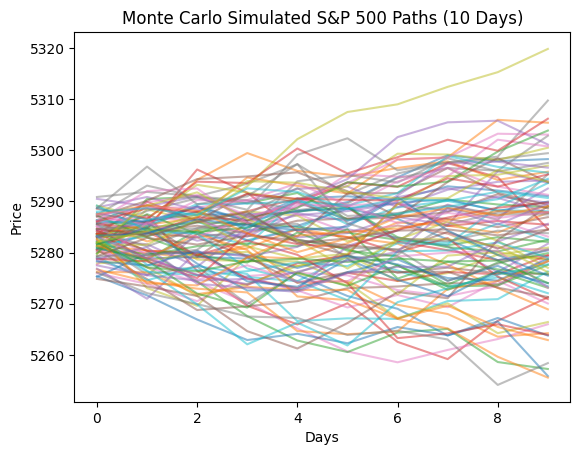

In [33]:
price_paths = monte_carlo_gbm(latest_price, mu, sigma, days=10, n_simulations=10_000)

# Plot 100 random paths
plt.plot(price_paths[:, :100], alpha=0.5)
plt.title('Monte Carlo Simulated S&P 500 Paths (10 Days)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

## Monte Carlo using historic price (Bootstrap)

In [34]:
def monte_carlo_bootstrap(start_price, daily_returns, days=1, n_simulations=10_000):
    simulated_returns = np.random.choice(daily_returns, size=(days, n_simulations))
    price_paths = start_price * (1 + simulated_returns).cumprod(axis=0)
    return price_paths

price_paths = monte_carlo_bootstrap(latest_price, daily_returns, days=1, n_simulations=10_000)

In [35]:
simulated_returns = np.random.choice(daily_returns, size=10_000)  # For bootstrap

In [42]:
simulated_returns = pd.DataFrame(simulated_returns)
simulated_returns.isna().sum()
# Drop NaN values
simulated_returns = simulated_returns.dropna()

In [43]:
var_95 = np.percentile(simulated_returns, 5)
print(f"1-Day 95% VaR: {var_95 * 100:.2f}%")
print(f"Absolute VaR for ${latest_price:.0f} portfolio: ${latest_price * var_95:.2f}")

1-Day 95% VaR: -1.66%
Absolute VaR for $5283 portfolio: $-87.92


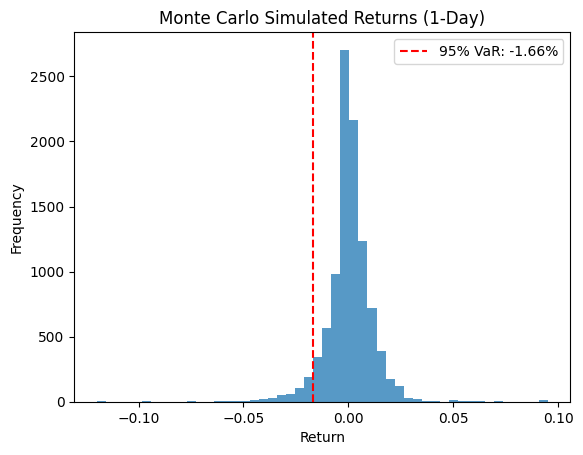

In [44]:
plt.hist(simulated_returns, bins=50, alpha=0.75)
plt.axvline(x=var_95, color='red', linestyle='--', label=f'95% VaR: {var_95 * 100:.2f}%')
plt.title('Monte Carlo Simulated Returns (1-Day)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [50]:
def expected_shortfall(returns, var_pct):
    var = np.percentile(returns, var_pct)
    es = np.mean(returns[returns <= var])  # Use np.mean instead of .mean()
    return es

# Calculate ES (works for both 1D and 2D)
es_simulated = expected_shortfall(simulated_returns, var_pct_mut)
print(f"Expected Shortfall (Simulated): {es_simulated * 100:.2f}%")

Expected Shortfall (Simulated): -11.98%


In [52]:
es_simulated*latest_price

-633.0814243347518